<a href="https://colab.research.google.com/github/dingyida/reinforce-learning/blob/main/lab7_mbrl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 7: Model Based Reinforcement Learning
In this lab, we will star practicing about Gaussian Process and then we will apply it to Model Based RL (MBRL).

## Exercise 1: Intro to Gaussian Processes with GPyTorch

***Objective:*** Build intuition for Gaussian Processes (GPs) by:
- Fitting an **exact GP** to noisy 1D data
- Visualizing **posterior mean + uncertainty**
- Understanding the effects of **noise** and **lengthscale**
- Exploring **extrapolation** (add a linear mean)
- Trying a **sparse GP** with inducing points (optional)

For more information. Check the GP Tutorial: https://docs.gpytorch.ai/en/v1.6.0/examples/01_Exact_GPs/Simple_GP_Regression.html

---

### Data
Use a 1D function with noise:
- f(x) = sin(2πx) + 0.3 * sin(6πx) + 3
- x ∈ [-1.0, 1.0]
- Add Gaussian noise σ_n (try 0.05 and 0.2)

---

## Tasks

### Part A — Exact GP regression (RBF kernel)
1. Implement an **ExactGP** model in GPyTorch:
   - Mean: `ZeroMean`
   - Covariance: `ScaleKernel(RBFKernel)`
   - Likelihood: `GaussianLikelihood`
2. Train by **maximizing log marginal likelihood** (Adam).
3. Plot:
   - Training points
   - Posterior mean
   - 95% confidence band

### Part B — Hyperparameters & data noise
1. Vary the **noise level** in the data (e.g., 0.05 vs 0.2).
2. For each setting, re-train the GP and report learned:
   - `likelihood.noise` (data noise)
   - `kernel.lengthscale`
3. Discuss how these affect smoothness and the width of uncertainty.

### Part C — Extrapolation behavior
1. **Hold out** the rightmost region (e.g., train on x ∈ [-1, 0.5], test on x ∈ (0.5, 1]).
2. Show how the posterior behaves outside the training region.
3. Add a **linear mean** (or `ConstantMean + LinearMean`) and compare extrapolation.

### Part D — (Graduate level) Sparse GP with inducing points
1. Replace Exact GP with **variational inducing-point GP** (SVGP) using `gpytorch.models.ApproximateGP`.
2. Choose M = 32 or 64 inducing points spread across x.
3. Compare posterior to the exact GP.
4. Plot N (number of samples) Vs training time for SVGP and ExactGP

---

## Deliverables
- Code for Parts A–C (Part D for grad students)
- Plots:
  - Mean ± 2 std band with training data
  - Effect of noise and lengthscale
  - Extrapolation comparison (zero vs linear/constant mean)
- Short write-up (≤1 page, as a cell in the notebook):
  - What did increasing noise do to learned hyperparameters and uncertainty?
  - How does the kernel lengthscale affect fit and confidence?
  - Why does the GP behave the way it does when extrapolating? How did the mean function change that?
  - (Grad level) Sparse vs Exact: trade-offs you observed

---

## Hints
- Normalize tensors to `float32` and move to GPU if available.
- Use `model.train(); likelihood.train()` for training, and `.eval()` for evaluation.
- For plotting uncertainty: `lower, upper = pred.confidence_region()`.
- Clip very small noise/lengthscale during early training if it becomes unstable.
- For SVGP, look at: `gpytorch.variational`, `gpytorch.mlls.VariationalELBO`.



In [1]:
## Install required libraries
!pip -q install gpytorch torch matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 6.7 MB/s eta 0:00:00


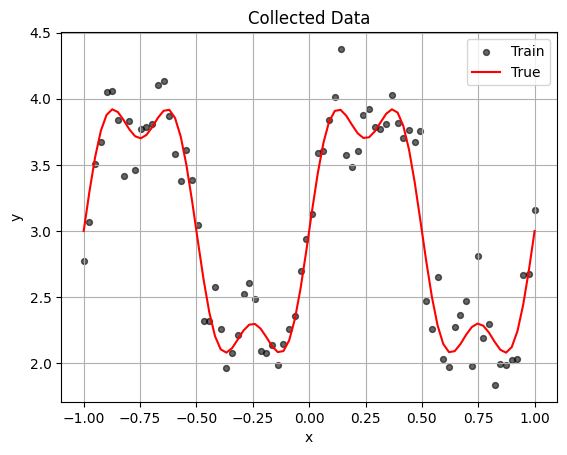

In [17]:
# =======================
# Collecting DATA
# =======================
import torch, math
import gpytorch
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

# Parameter for data generator
NOISE_STD = 0.2
N = 80

def f(x):
  return torch.sin(2*math.pi*x) + 0.3*torch.sin(6*math.pi*x) + 3


# ---------- Data ----------
def make_data(n=80, noise_std=0.05, train_range=(-1.0, 1.0), holdout_right=False):
    x = torch.linspace(train_range[0], train_range[1], n)
    y_clean = f(x)
    y = y_clean + noise_std*torch.randn_like(y_clean)
    if holdout_right:
        mask = x <= 0.5
        return x[mask].unsqueeze(-1), y[mask], x.unsqueeze(-1), y
    else:
        return x.unsqueeze(-1), y, x.unsqueeze(-1), y

# choose setting
Xtr, Ytr, Xgrid, Ygrid = make_data(n=N, noise_std=NOISE_STD, holdout_right=False)
Xtr, Ytr, Xgrid = Xtr.to(device), Ytr.to(device), Xgrid.to(device)

# Plot data
plt.scatter(Xtr.cpu(), Ytr.cpu(), s=18, color='k', alpha=0.6, label='Train')
plt.plot(Xgrid.cpu(), f(Xgrid.cpu()), 'r', label='True')
plt.title('Collected Data')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(True)
plt.show()


In [26]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        # TODO (Part A): pick a mean; start with ZeroMean (try Constant/Linear in Part C)
        self.mean_module = gpytorch.means.ZeroMean()
        # TODO (Part A): kernel = ScaleKernel(RBFKernel)
        self.covar_module = gpytorch.kernels.ScaleKernel(
           gpytorch.kernels.RBFKernel()
)
        self.covar_module.base_kernel.initialize(lengthscale=0.1)
        self.covar_module.base_kernel.raw_lengthscale.requires_grad = False

    def forward(self, x):
        mean_x  = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Likelihood + model
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = ExactGPModel(Xtr, Ytr, likelihood).to(device)

iter  200 | loss 0.012 | lengthscale 0.100 | noise 0.0080
iter  400 | loss 0.010 | lengthscale 0.100 | noise 0.0080
iter  600 | loss 0.010 | lengthscale 0.100 | noise 0.0080
iter  800 | loss 0.010 | lengthscale 0.100 | noise 0.0080


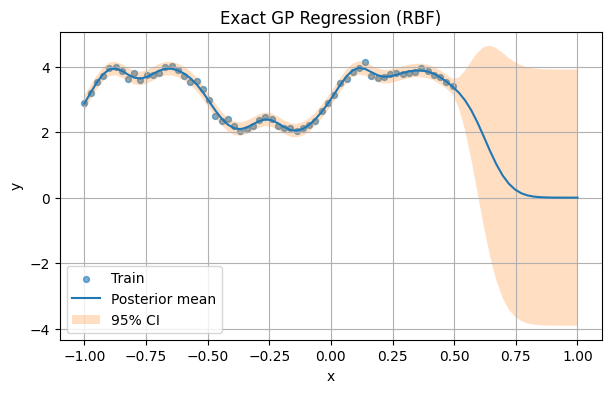

In [27]:
# ---------- Train (maximize log marginal likelihood) ----------
training_iter = 800
model.train(); likelihood.train()
optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.05)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(Xtr)
    loss = -mll(output, Ytr)
    loss.backward()
    optimizer.step()
    if (i+1) % 200 == 0:
        ls = model.covar_module.base_kernel.lengthscale.item()
        sn = likelihood.noise.item()
        print(f"iter {i+1:4d} | loss {loss.item():.3f} | lengthscale {ls:.3f} | noise {sn:.4f}")

# ---------- Evaluate ----------
model.eval(); likelihood.eval()

# Make test grid on the SAME device as training/model, and as 2D (N,1)
x2 = torch.linspace(-1, 1, N, device=Xtr.device).unsqueeze(-1)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = likelihood(model(x2))
    mean = pred.mean.detach().cpu().squeeze()
    lower, upper = pred.confidence_region()
    lower, upper = lower.detach().cpu(), upper.detach().cpu()

x2_cpu   = x2.detach().cpu().squeeze()
Xtr_cpu  = Xtr.detach().cpu().squeeze()
Ytr_cpu  = Ytr.detach().cpu()

# ---------- Plot ----------
plt.figure(figsize=(7,4))
plt.scatter(Xtr_cpu, Ytr_cpu, s=18, alpha=0.6, label='Train')
plt.plot(x2_cpu, mean, label='Posterior mean')
plt.fill_between(x2_cpu, lower, upper, alpha=0.25, label='95% CI')
plt.title('Exact GP Regression (RBF)')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(True); plt.show()



iter  200 | loss 0.251 | lengthscale 0.383 | noise 0.0526
iter  400 | loss 0.246 | lengthscale 0.392 | noise 0.0526
iter  600 | loss 0.245 | lengthscale 0.397 | noise 0.0526
iter  800 | loss 0.244 | lengthscale 0.399 | noise 0.0526
Test MSE on (0.5, 1]: 0.3637


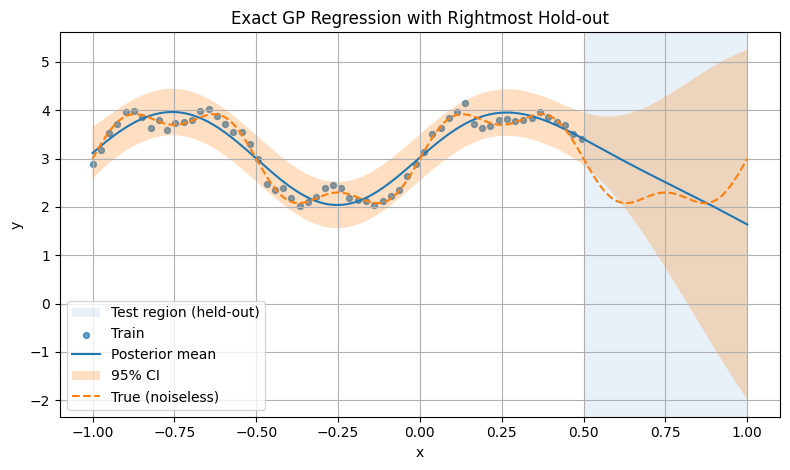

In [24]:
# =======================
# Imports & setup
# =======================
import math
import torch
import gpytorch
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

# =======================
# Data generator
# =======================
NOISE_STD = 0.1
N = 80  # base grid density for data gen

def f(x):
    # x can be 1D or 2D tensor; ensure math works with torch
    return torch.sin(2*math.pi*x) + 0.3*torch.sin(6*math.pi*x) + 3

def make_data(n=80, noise_std=0.05, train_range=(-1.0, 1.0), holdout_right=False):
    """
    Returns:
      If holdout_right=False:
        Xtr [n,1], Ytr [n], Xgrid [n,1], Ygrid [n]
      If holdout_right=True:
        Xtr is only the left part (x <= 0.5), Ytr same,
        Xgrid,Ygrid are full grid on [train_range[0], train_range[1]]
    """
    x = torch.linspace(train_range[0], train_range[1], n)
    y_clean = f(x)
    y = y_clean + noise_std * torch.randn_like(y_clean)
    if holdout_right:
        mask = x <= 0.5
        return x[mask].unsqueeze(-1), y[mask], x.unsqueeze(-1), y
    else:
        return x.unsqueeze(-1), y, x.unsqueeze(-1), y

# =======================
# Exact GP model
# =======================
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module  = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x  = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# =======================
# 1) Make split: train on [-1, 0.5], hold out (0.5, 1]
# =======================
Xtr, Ytr, Xgrid, Ygrid = make_data(n=N, noise_std=NOISE_STD, holdout_right=True)
Xtr, Ytr, Xgrid, Ygrid = Xtr.to(device), Ytr.to(device), Xgrid.to(device), Ygrid.to(device)

# Recreate likelihood + model AFTER making the split (Option A)
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = ExactGPModel(Xtr, Ytr, likelihood).to(device)

# =======================
# 2) Train (maximize log marginal likelihood)
# =======================
training_iter = 800
model.train(); likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(Xtr)
    loss = -mll(output, Ytr)
    loss.backward()
    optimizer.step()

    if (i + 1) % 200 == 0:
        ls = model.covar_module.base_kernel.lengthscale.detach().cpu().squeeze().item()
        sn = likelihood.noise.detach().cpu().item()
        print(f"iter {i+1:4d} | loss {loss.item():.3f} | lengthscale {ls:.3f} | noise {sn:.4f}")

# =======================
# 3) Evaluate on full grid [-1, 1]
# =======================
model.eval(); likelihood.eval()

# Dense grid for smooth curves
x2 = torch.linspace(-1, 1, 400, device=device).unsqueeze(-1)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = likelihood(model(x2))
    mean = pred.mean.detach().cpu().squeeze()
    lower, upper = pred.confidence_region()
    lower, upper = lower.detach().cpu(), upper.detach().cpu()

x2_cpu = x2.detach().cpu().squeeze()
f_true = f(x2_cpu)

# Compute simple test MSE on held-out region (0.5, 1]
test_mask = x2_cpu > 0.5
test_mse = float(torch.mean((mean[test_mask] - f_true[test_mask])**2))
print(f"Test MSE on (0.5, 1]: {test_mse:.4f}")

# =======================
# 4) Plot
# =======================
Xtr_cpu = Xtr.detach().cpu().squeeze()
Ytr_cpu = Ytr.detach().cpu()

plt.figure(figsize=(8, 4.8))

# Shade held-out test region
plt.axvspan(0.5, 1.0, alpha=0.10, label='Test region (held-out)')

# Training data
plt.scatter(Xtr_cpu, Ytr_cpu, s=18, alpha=0.7, label='Train')

# Posterior mean & CI
plt.plot(x2_cpu, mean, label='Posterior mean')
plt.fill_between(x2_cpu, lower, upper, alpha=0.25, label='95% CI')

# True function (noiseless)
plt.plot(x2_cpu, f_true, linestyle='--', label='True (noiseless)')

plt.title('Exact GP Regression with Rightmost Hold-out')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(loc='best'); plt.grid(True)
plt.tight_layout()
plt.show()


## Exercise 2 (Optional, except PhD students): Model-Based Reinforcement Learning with Gaussian Process + MPC
***Goal:***
Learn the core ideas of **Model-Based Reinforcement Learning (MBRL)** by:
- Learning a **dynamics model** with a Gaussian Process (GP)
- Using **Model Predictive Control (MPC)** to plan actions
- Comparing against random or fixed policies

We’ll use a simplified version of **GP-MPC** (similar in spirit to PILCO or PETS) on the *MountainCarContinuous-v0* task.

---

## 1 Background
The system dynamics are unknown.  
We collect transitions
\[
(x_t, u_t, r_t, x_{t+1})
\]
and learn a GP model of the change in state:
\[
\Delta x = f(x_t, u_t) + \varepsilon
\]
Then, given a current state, we **simulate** future trajectories using the GP mean prediction and pick an action sequence that maximizes the expected reward (or minimizes cost) over a short horizon — the **MPC** loop.

---

## 2 Steps

### Part A — Collect data with a random policy
1. Run `N = 1000` random actions.
2. Store transitions \((x_t, u_t, x_{t+1})\).
3. Compute state differences:  
   `dx = x_next - x`.

### Part B — Train a Gaussian Process model
1. Fit a GP for each state dimension (here 2: position and velocity).  
   Inputs = `[x_t, u_t]`  
   Outputs = `dx_t`
2. Use **GPyTorch** or **sklearn.gaussian_process**.
3. Plot model predictions vs. ground truth for a few samples.

### Part C — Implement a simple MPC controller
1. At each step:
   - Start from current state \(x_t\).
   - Sample \(K\) random control sequences of horizon \(H\).
   - For each sequence, **simulate forward** using GP predictions.
   - Compute cumulative reward (from MountainCarContinuous env).
   - Execute the *first action* of the best sequence.
2. Repeat until termination or max steps.

### Part D — Evaluate and visualize
1. Plot the car’s trajectory (position vs. time).
2. Compare with random policy performance.
3. Discuss:  
   - How does the GP model’s accuracy affect control?  
   - How many random samples or planning horizon are needed?

---

## Deliverables
- Code for data collection, GP training, and MPC loop.
- Plots:
  - GP predictions vs. true next states.
  - Car’s position vs. time during control.
- Short discussion (≈½ page):
  - How did planning horizon affect performance?
  - How does GP uncertainty limit long-term planning?

---

## Optional extensions
- Add GP uncertainty penalty in cost function.
- Try a learned NN model instead of GP.
- Use warm-start data from a heuristic controller.
- Compare Exact GP vs. Sparse GP (SVGP).

---

## Hints
- Normalize inputs and outputs before GP training.
- Use a small horizon (H≈15–20) for efficiency.
- Reward function from environment:
  ```python
  reward = 100 * (abs(x) >= 0.45) - 0.1 * u**2

## Exercise 3: Getting Started with MuJoCo and XML Models
***Goal:***
The goal of this exercise is to **install MuJoCo**, explore its **Python interface**, and learn the structure of **MJCF (XML) models** used to describe robots and environments.  
By the end, you should be able to:
- Run a MuJoCo simulation locally  
- Open, modify, and reload a simple XML model  
- Use Google Colab connected to your local runtime

---

MuJoCo (“Multi-Joint dynamics with Contact”) is a fast physics engine widely used in robotics and reinforcement learning.  
It uses XML (MJCF files) to describe bodies, joints, sensors, and actuators.

In this exercise, you will:
1. Install MuJoCo on your computer  
2. Install and run Jupyter Notebook or Lab  
3. Connect Colab to your local runtime  
4. Run Mujco with existent XML (car, quadrotor, mountain)
6. Create a scene with multiple falling objects

---
## Step-by-Step Instructions
### 1 Install MuJoCo: Download and install
- Visit [https://mujoco.org/download](https://mujoco.org/download)  
- Choose the installer for your OS (Windows, macOS, or Linux)

### 2 Install Jupyter

You can use either JupyterLab or Jupyter Notebook

```
pip install jupyterlab
```

Run
```
jupyter lab
```
This should open your browser at:
```
http://localhost:8888/lab
```

### 3 Configure Google Colab to Run Locally

### 4 Run a Simple MuJoCo Simulation


In [ ]:
import mujoco as mj
from mujoco.glfw import glfw
import numpy as np
import os

XML = r"""
<mujoco>
	<worldbody>
        <light diffuse=".5 .5 .5" pos="0 0 3" dir="0 0 -1"/>
		<geom type="plane" size="1 1 0.1" rgba=".9 0 0 1"/>
		<body pos="0 0 1">
			<joint type="free"/>
			<geom type="box" size=".1 .2 .3" rgba="0 .9 0 1"/>
		</body>
	</worldbody>
</mujoco>
"""


simend = 15 #simulation time


# For callback functions
button_left = False
button_middle = False
button_right = False
lastx = 0
lasty = 0

def init_controller(model,data):
    #initialize the controller here. This function is called once, in the beginning
    pass

def controller(model, data):
    #put the controller here. This function is called inside the simulation.
    pass

def keyboard(window, key, scancode, act, mods):
    if act == glfw.PRESS and key == glfw.KEY_BACKSPACE:
        mj.mj_resetData(model, data)
        mj.mj_forward(model, data)

def mouse_button(window, button, act, mods):
    # update button state
    global button_left
    global button_middle
    global button_right

    button_left = (glfw.get_mouse_button(
        window, glfw.MOUSE_BUTTON_LEFT) == glfw.PRESS)
    button_middle = (glfw.get_mouse_button(
        window, glfw.MOUSE_BUTTON_MIDDLE) == glfw.PRESS)
    button_right = (glfw.get_mouse_button(
        window, glfw.MOUSE_BUTTON_RIGHT) == glfw.PRESS)

    # update mouse position
    glfw.get_cursor_pos(window)

def mouse_move(window, xpos, ypos):
    # compute mouse displacement, save
    global lastx
    global lasty
    global button_left
    global button_middle
    global button_right

    dx = xpos - lastx
    dy = ypos - lasty
    lastx = xpos
    lasty = ypos

    # no buttons down: nothing to do
    if (not button_left) and (not button_middle) and (not button_right):
        return

    # get current window size
    width, height = glfw.get_window_size(window)

    # get shift key state
    PRESS_LEFT_SHIFT = glfw.get_key(
        window, glfw.KEY_LEFT_SHIFT) == glfw.PRESS
    PRESS_RIGHT_SHIFT = glfw.get_key(
        window, glfw.KEY_RIGHT_SHIFT) == glfw.PRESS
    mod_shift = (PRESS_LEFT_SHIFT or PRESS_RIGHT_SHIFT)

    # determine action based on mouse button
    if button_right:
        if mod_shift:
            action = mj.mjtMouse.mjMOUSE_MOVE_H
        else:
            action = mj.mjtMouse.mjMOUSE_MOVE_V
    elif button_left:
        if mod_shift:
            action = mj.mjtMouse.mjMOUSE_ROTATE_H
        else:
            action = mj.mjtMouse.mjMOUSE_ROTATE_V
    else:
        action = mj.mjtMouse.mjMOUSE_ZOOM

    mj.mjv_moveCamera(model, action, dx/height,
                      dy/height, scene, cam)

def scroll(window, xoffset, yoffset):
    action = mj.mjtMouse.mjMOUSE_ZOOM
    mj.mjv_moveCamera(model, action, 0.0, -0.05 *
                      yoffset, scene, cam)

# MuJoCo data structures
model = mj.MjModel.from_xml_string(XML)  # MuJoCo model
data = mj.MjData(model)                # MuJoCo data
cam = mj.MjvCamera()                        # Abstract camera
opt = mj.MjvOption()                        # visualization options

# Init GLFW, create window, make OpenGL context current, request v-sync
glfw.init()
window = glfw.create_window(1200, 900, "Demo", None, None)
glfw.make_context_current(window)
glfw.swap_interval(1)

# initialize visualization data structures
mj.mjv_defaultCamera(cam)
mj.mjv_defaultOption(opt)
scene = mj.MjvScene(model, maxgeom=10000)
context = mj.MjrContext(model, mj.mjtFontScale.mjFONTSCALE_150.value)

# install GLFW mouse and keyboard callbacks
glfw.set_key_callback(window, keyboard)
glfw.set_cursor_pos_callback(window, mouse_move)
glfw.set_mouse_button_callback(window, mouse_button)
glfw.set_scroll_callback(window, scroll)


#initialize the controller
init_controller(model,data)

#set the controller
mj.set_mjcb_control(controller)

while not glfw.window_should_close(window):
    time_prev = data.time

    while (data.time - time_prev < 1.0/60.0):
        mj.mj_step(model, data)

    if (data.time>=simend):
        break

    # get framebuffer viewport
    viewport_width, viewport_height = glfw.get_framebuffer_size(
        window)
    viewport = mj.MjrRect(0, 0, viewport_width, viewport_height)

    # Update scene and render
    mj.mjv_updateScene(model, data, opt, None, cam,
                       mj.mjtCatBit.mjCAT_ALL.value, scene)
    mj.mjr_render(viewport, scene, context)

    # swap OpenGL buffers (blocking call due to v-sync)
    glfw.swap_buffers(window)

    # process pending GUI events, call GLFW callbacks
    glfw.poll_events()

glfw.terminate()


# Test with the following XMLs

In [ ]:
# CAR
XML = r"""
<mujoco model="simple_car_gazebo_style">
  <option gravity="0 0 -9.81" integrator="RK4" timestep="0.002"/>
  <compiler angle="radian"/>

  <visual>
    <quality shadowsize="4096"/>
    <rgba haze="0.9 0.95 1.0 0.12"/>
  </visual>

  <asset>
    <texture name="sky" type="skybox" builtin="gradient"
             rgb1="0.75 0.85 0.95" rgb2="0.95 0.95 0.98" width="1024" height="1024"/>
    <texture name="grid" type="2d" builtin="checker" width="1024" height="1024"
             rgb1="0.36 0.39 0.42" rgb2="0.40 0.43 0.46" mark="edge" markrgb="0.62 0.66 0.70"/>
    <material name="ground_mat" texture="grid" texrepeat="40 40"
              specular="0.05" shininess="0.3" reflectance="0.2" rgba="1 1 1 1"/>
    <material name="chassis_mat" rgba="0.12 0.30 0.75 1" specular="0.2" shininess="0.4"/>
    <material name="tire_mat"    rgba="0.07 0.07 0.07 1" specular="0.05" shininess="0.2"/>
  </asset>

  <default>
    <!-- No default rgba here; let materials show through -->
    <geom contype="1" conaffinity="1" friction="1.0 0.1 0.01" density="500"/>
    <joint limited="false" damping="0.1"/>
    <motor ctrlrange="-2 2"/>
  </default>

  <worldbody>
    <light name="sun_dir" directional="true" castshadow="true"
           pos="0 0 5" dir="0.2 0.3 -1" diffuse="0.9 0.9 0.9" specular="0.2 0.2 0.2" ambient="0.2 0.2 0.25"/>
    <light name="fill" directional="true" castshadow="false"
           pos="0 0 3" dir="-0.3 -0.2 -1" diffuse="0.3 0.3 0.35" specular="0 0 0" ambient="0.15 0.15 0.18"/>

    <geom name="floor" type="plane" pos="0 0 0" size="20 20 0.1" material="ground_mat"/>

    <!-- Chassis center at z=0.22 = wheel_radius(0.10)+half_chassis(0.10)+clearance(0.02) -->
    <body name="chassis" pos="0 0 0.22">
      <freejoint name="chassis_free"/>
      <geom name="chassis_box" type="box" size="0.40 0.25 0.10" material="chassis_mat"/>

      <!-- Wheel radius=0.10; centers should be at absolute z=0.10.
           Relative z offset = 0.10 - 0.22 = -0.12 (below chassis center). -->
      <!-- Cylinder axis along y: rotate +90deg about x -->
      <body name="wheel_fl" pos=" 0.35  0.22 -0.12">
        <joint name="j_fl" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  name="g_fl" type="cylinder" size="0.10 0.05" euler="1.57079632679 0 0" material="tire_mat"/>
      </body>

      <body name="wheel_fr" pos=" 0.35 -0.22 -0.12">
        <joint name="j_fr" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  name="g_fr" type="cylinder" size="0.10 0.05" euler="1.57079632679 0 0" material="tire_mat"/>
      </body>

      <body name="wheel_rl" pos="-0.35  0.22 -0.12">
        <joint name="j_rl" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  name="g_rl" type="cylinder" size="0.10 0.05" euler="1.57079632679 0 0" material="tire_mat"/>
      </body>

      <body name="wheel_rr" pos="-0.35 -0.22 -0.12">
        <joint name="j_rr" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  name="g_rr" type="cylinder" size="0.10 0.05" euler="1.57079632679 0 0" material="tire_mat"/>
      </body>
    </body>
  </worldbody>

  <actuator>
    <motor name="m_fl" joint="j_fl" gear="120"/>
    <motor name="m_fr" joint="j_fr" gear="120"/>
    <motor name="m_rl" joint="j_rl" gear="120"/>
    <motor name="m_rr" joint="j_rr" gear="120"/>
  </actuator>
</mujoco>



"""

In [ ]:
## Drone
XML = r"""
<mujoco model="quad2d">
  <option gravity="0 0 -9.81" timestep="0.005"/>
  <worldbody>
    <body name="quad" pos="0 0 1">
      <!-- 2D DOF -->
      <joint name="x"     type="slide" axis="1 0 0" limited="false"/>
      <joint name="z"     type="slide" axis="0 0 1" limited="false"/>
      <joint name="pitch" type="hinge" axis="0 1 0" limited="false"/>

      <!-- frame -->
      <geom type="box" size="0.15 0.02 0.01" rgba="0.2 0.5 0.8 1"/>

      <!-- thruster sites (±arm) -->
      <site name="left"  pos="-0.15 0 0" size="0.01" rgba="1 0 0 1"/>
      <site name="right" pos="+0.15 0 0" size="0.01" rgba="0 1 0 1"/>

      <!-- mass/inertia (defaults are fine for demo) -->
      <inertial pos="0 0 0" mass="0.6" diaginertia="0.002 0.002 0.004"/>
    </body>

    <!-- ground plane -->
    <geom name="ground" type="plane" pos="0 0 0" size="5 5 0.1" rgba="0.8 0.8 0.8 1"/>
  </worldbody>

<actuator>
  <!-- Control u in [0, 20]; actual applied force = gainprm[0] * u along gear direction -->
  <general name="thrust_left"  site="left"
           biastype="affine" gainprm="1"
           ctrllimited="true" ctrlrange="0 20"
           gear="0 0 1  0 0 0"/>

  <general name="thrust_right" site="right"
           biastype="affine" gainprm="1"
           ctrllimited="true" ctrlrange="0 20"
           gear="0 0 1  0 0 0"/>
</actuator>


  <sensor>
    <framepos    name="pos"  objtype="body" objname="quad"/>
    <frameangvel name="omega" objtype="body" objname="quad"/>
    <framelinvel name="vlin"  objtype="body" objname="quad"/>
  </sensor>
</mujoco>
"""

In [ ]:
# Mountain

XML = r"""
<mujoco model="car_on_piecewise_curved_ramp">
  <option gravity="0 0 -9.81" integrator="RK4" timestep="0.002"/>
  <compiler angle="radian"/>

  <visual>
    <quality shadowsize="4096"/>
    <rgba haze="0.9 0.95 1.0 0.10"/>
  </visual>

  <asset>
    <texture name="sky" type="skybox" builtin="gradient"
             rgb1="0.75 0.85 0.95" rgb2="0.95 0.95 0.98" width="1024" height="1024"/>
    <texture name="grid" type="2d" builtin="checker" width="1024" height="1024"
             rgb1="0.36 0.39 0.42" rgb2="0.40 0.43 0.46" mark="edge" markrgb="0.62 0.66 0.70"/>
    <material name="ground_mat" texture="grid" texrepeat="12 2"
              specular="0.05" shininess="0.3" reflectance="0.08" rgba="1 1 1 1"/>

    <!-- Car materials -->
    <material name="paint" rgba="0.10 0.22 0.70 1" specular="0.45" shininess="0.7" reflectance="0.10"/>
    <material name="glass" rgba="0.20 0.28 0.35 0.35" specular="0.6" shininess="0.8" reflectance="0.1"/>
    <material name="tire"  rgba="0.06 0.06 0.06 1" specular="0.05" shininess="0.2"/>
    <material name="rim"   rgba="0.85 0.85 0.88 1" specular="0.6" shininess="0.8"/>
    <material name="black" rgba="0.04 0.04 0.05 1" specular="0.1" shininess="0.2"/>
  </asset>

  <default>
    <geom contype="1" conaffinity="1" friction="1.3 0.1 0.01" density="500"/>
    <joint limited="false" damping="0.1"/>
    <motor ctrlrange="-2 2"/>
  </default>

  <worldbody>
    <light name="sun" directional="true" castshadow="true"
           pos="0 0 8" dir="0.25 0.3 -1" diffuse="0.9 0.9 0.9" specular="0.2 0.2 0.2" ambient="0.2 0.2 0.25"/>
    <light name="fill" directional="true" castshadow="false"
           pos="-2 -2 4" dir="0.3 0.1 -1" diffuse="0.35 0.35 0.4" specular="0 0 0" ambient="0.15 0.15 0.18"/>

    <camera name="valley_view" mode="fixed" pos="-3.2 -1.2 1.3" euler="0.12 0.42 0.8" fovy="45"/>

    <!-- ========= Piecewise-curved ramp (sign-corrected pitches) =========
         z(x) = 0.15 x^2  ->  dz/dx = 0.30 x  ->  pitch θy = -atan(0.30 x)
         Centers at x = [-2.25, -1.75, -1.25, -0.75, -0.25, 0, 0.25, 0.75, 1.25, 1.75, 2.25]
    -->
    <geom name="seg_m2_25" type="box" size="0.25 1.0 0.02" pos="-2.25 0 0.759" euler="0  0.595 0" material="ground_mat"/>
    <geom name="seg_m1_75" type="box" size="0.25 1.0 0.02" pos="-1.75 0 0.459" euler="0  0.487 0" material="ground_mat"/>
    <geom name="seg_m1_25" type="box" size="0.25 1.0 0.02" pos="-1.25 0 0.234" euler="0  0.358 0" material="ground_mat"/>
    <geom name="seg_m0_75" type="box" size="0.25 1.0 0.02" pos="-0.75 0 0.084" euler="0  0.221 0" material="ground_mat"/>
    <geom name="seg_m0_25" type="box" size="0.25 1.0 0.02" pos="-0.25 0 0.009" euler="0  0.075 0" material="ground_mat"/>
    <geom name="seg_0"     type="box" size="0.25 1.0 0.02" pos=" 0.00 0 0.000" euler="0  0.000 0" material="ground_mat"/>
    <geom name="seg_p0_25" type="box" size="0.25 1.0 0.02" pos=" 0.25 0 0.009" euler="0 -0.075 0" material="ground_mat"/>
    <geom name="seg_p0_75" type="box" size="0.25 1.0 0.02" pos=" 0.75 0 0.084" euler="0 -0.221 0" material="ground_mat"/>
    <geom name="seg_p1_25" type="box" size="0.25 1.0 0.02" pos=" 1.25 0 0.234" euler="0 -0.358 0" material="ground_mat"/>
    <geom name="seg_p1_75" type="box" size="0.25 1.0 0.02" pos=" 1.75 0 0.459" euler="0 -0.487 0" material="ground_mat"/>
    <geom name="seg_p2_25" type="box" size="0.25 1.0 0.02" pos=" 2.25 0 0.759" euler="0 -0.595 0" material="ground_mat"/>
    <geom name="ground"    type="plane" pos="0 0 -0.02" size="10 10 0.1" material="ground_mat"/>

        <!-- Translucent narrow walls to keep the car aligned -->
    <geom name="left_wall"
          type="box"
          size="2.6 0.02 0.5"
          pos="0  0.2 0.45"
          rgba="0.6 0.8 1.0 0.15"
          material="ground_mat"/>

    <geom name="right_wall"
          type="box"
          size="2.6 0.02 0.5"
          pos="0 -0.2 0.45"
          rgba="0.6 0.8 1.0 0.15"
          material="ground_mat"/>



    <!-- ===== Car (same spec as before, slightly smaller) ===== -->
    <body name="chassis" pos="-1.5 0 0.70">
      <freejoint/>
      <geom type="box"       size="0.24 0.15 0.06" material="paint"/>
      <geom type="ellipsoid" size="0.15 0.12 0.06" pos="0.03 0 0.07" material="glass"/>
      <geom type="box"       size="0.05 0.15 0.02" pos="-0.30 0 -0.03" material="black"/>

      <!-- Wheels: radius=0.05, axle along local y -->
      <body name="wheel_fl" pos=" 0.20  0.13 -0.085">
        <joint name="j_fl" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  type="cylinder" size="0.05 0.03" euler="1.57079632679 0 0" material="tire"/>
        <geom  type="cylinder" size="0.037 0.031" euler="1.57079632679 0 0" material="rim"/>
      </body>
      <body name="wheel_fr" pos=" 0.20 -0.13 -0.085">
        <joint name="j_fr" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  type="cylinder" size="0.05 0.03" euler="1.57079632679 0 0" material="tire"/>
        <geom  type="cylinder" size="0.037 0.031" euler="1.57079632679 0 0" material="rim"/>
      </body>
      <body name="wheel_rl" pos="-0.19  0.13 -0.085">
        <joint name="j_rl" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  type="cylinder" size="0.05 0.03" euler="1.57079632679 0 0" material="tire"/>
        <geom  type="cylinder" size="0.037 0.031" euler="1.57079632679 0 0" material="rim"/>
      </body>
      <body name="wheel_rr" pos="-0.19 -0.13 -0.085">
        <joint name="j_rr" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  type="cylinder" size="0.05 0.03" euler="1.57079632679 0 0" material="tire"/>
        <geom  type="cylinder" size="0.037 0.031" euler="1.57079632679 0 0" material="rim"/>
      </body>
    </body>
  </worldbody>

  <actuator>
    <motor joint="j_fl" gear="120"/>
    <motor joint="j_fr" gear="120"/>
    <motor joint="j_rl" gear="120"/>
    <motor joint="j_rr" gear="120"/>
  </actuator>
</mujoco>


"""

## Create a Scene with Falling Objects

Now let’s create a small **physics scene** to understand how MuJoCo handles **contacts and collisions**.

You’ll build an XML with **two cubes and one sphere**, stacked vertically so that they fall and collide naturally under gravity.

Add a screenshot in a cell of the notebook.